In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import missingno as msno # visualizing missing values
import seaborn as sns # for data visualization
import matplotlib.pyplot as plt # for plot
%matplotlib inline

import torch 
import torch.nn as nn # For neural network building
import torch.nn.functional as F # For activation function
from torch.utils import data  # For data handling
from torch.utils.data import DataLoader, TensorDataset, SubsetRandomSampler
from sklearn.model_selection import train_test_split # For splitting the data
# from sklearn.model_selection import KFold # For kfold training

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv
/kaggle/input/house-prices-advanced-regression-techniques/data_description.txt
/kaggle/input/house-prices-advanced-regression-techniques/train.csv
/kaggle/input/house-prices-advanced-regression-techniques/test.csv


# Data Processing

In [2]:
# Load: data
df_train_raw = pd.read_csv(r'/kaggle/input/house-prices-advanced-regression-techniques/train.csv')

In [3]:
# Check the first 5 rows
df_train_raw.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [4]:
print(" CARDINALITY")
aux = pd.DataFrame(df_train_raw.nunique().sort_values(ascending = False))
aux.T

 CARDINALITY


,Id,LotArea,GrLivArea,BsmtUnfSF,1stFlrSF,TotalBsmtSF,SalePrice,BsmtFinSF1,GarageArea,2ndFlrSF,...,PavedDrive,GarageFinish,PoolQC,BsmtHalfBath,LandSlope,HalfBath,Street,CentralAir,Utilities,Alley
0,1460,1073,861,780,753,721,663,637,441,417,...,3,3,3,3,3,3,2,2,2,2


We want to remove Id column as it will be unecessary for our inputs

In [5]:
# Checking the (number of rows, number of columns)
df_train_raw.shape

(1460, 81)

# Statistical Hypotesis test's:

## 1) Numerical: Distribution Tests



1. **Shapiro-Wilk Test**: This test evaluates if a dataset comes from a normal distribution. A low p-value (typically less than 0.05) indicates that the data significantly deviates from normality. 

2. **D'Agostino Test**: This test checks for skewness and kurtosis to evaluate normality. Similar to the Shapiro-Wilk test, a low p-value indicates that the data is not normally distributed. Variables like "LotFrontage" have a p-value of 1, suggesting normality, while others like "LotArea" show extremely small p-values, signaling a departure from normality.

This could influence the choice of statistical methods used for further analysis (parametric vs. non-parametric methods). In this notebook we contrast both methods

In [6]:
import pandas as pd
import numpy as np
from scipy.stats import shapiro, normaltest


def norm_test(df):
    
    # Filtrar solo las columnas numéricas
    numerical_features = df.select_dtypes(include=[np.number])
    
    # Realizar tests de normalidad para cada característica numérica
    results = []
    
    for column in numerical_features.columns:
        data = df[column]
        
        # Shapiro-Wilk Test
        stat_shapiro, p_shapiro = shapiro(data)
        
        # D'Agostino's K-squared Test
        stat_dagostino, p_dagostino = normaltest(data)
        
        results.append({
            "Feature": column,
            "Shapiro-Wilk p-value": p_shapiro,
            "D'Agostino p-value": p_dagostino,
            "Shapiro Result": "Normal" if p_shapiro > 0.05 else "Not Normal",
            "D'Agostino Result": "Normal" if p_dagostino > 0.05 else "Not Normal"
        })
    
    # Crear un DataFrame con los resultados
    results_df = pd.DataFrame(results)
    
    # Mostrar los resultados
    display(results_df)

norm_test(df_train_raw)


,Feature,Shapiro-Wilk p-value,D'Agostino p-value,Shapiro Result,D'Agostino Result
0,Id,7.979264e-21,5.132322e-247,Not Normal,Not Normal
1,MSSubClass,9.105929e-39,6.037486e-74,Not Normal,Not Normal
2,LotFrontage,1.000000e+00,NaN,Normal,Not Normal
3,LotArea,0.000000e+00,0.000000e+00,Not Normal,Not Normal
4,OverallQual,2.689927e-22,2.599901e-03,Not Normal,Not Normal
5,OverallCond,6.778476e-37,3.092807e-29,Not Normal,Not Normal
6,YearBuilt,2.770050e-26,4.440905e-22,Not Normal,Not Normal
7,YearRemodAdd,6.725454e-34,0.000000e+00,Not Normal,Not Normal
8,MasVnrArea,1.000000e+00,NaN,Normal,Not Normal
9,BsmtFinSF1,2.814012e-35,2.499388e-139,Not Normal,Not Normal


In [7]:
# def histPlots(df):
#     train = df
#     num_columns = 3 
#     num_rows = len(train.columns) // num_columns + (1 if len(train.columns) % num_columns != 0 else 0)
    
#     fig, axes = plt.subplots(num_rows, num_columns, figsize=(15, num_rows * 5))
    
    
#     axes = axes.flatten()
    
    
#     for i, col in enumerate(train.select_dtypes(include=['float64', 'int64']).columns):
#         train[col].hist(ax=axes[i], bins=30)
#         axes[i].set_title(f'Histogram of {col}')
#         axes[i].set_xlabel(col)
#         axes[i].set_ylabel('Frec')
    
#     for j in range(i + 1, len(axes)):
#         fig.delaxes(axes[j])
    
#     plt.tight_layout()
#     plt.show()

# histPlots(df_train_raw)

Most of our features are not normal, so we will have to normalize them.


# Target: Visual Analysis

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


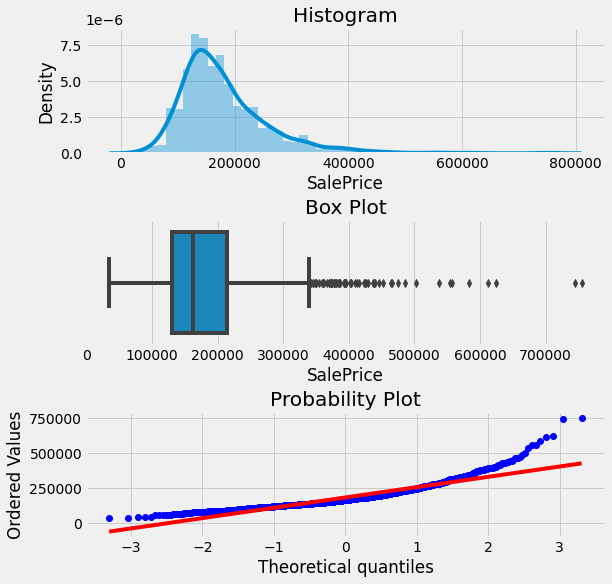

In [8]:
def plotting_3_chart(df, feature):
    ## Importing seaborn, matplotlib and scipy modules. 
    import seaborn as sns
    import matplotlib.pyplot as plt
    import matplotlib.gridspec as gridspec
    from scipy import stats
    import matplotlib.style as style
    style.use('fivethirtyeight')

    ## Creating a customized chart and setting the figsize.
    fig = plt.figure(constrained_layout=True, figsize=(12,8))
    ## Creating a grid with 3 columns and 3 rows. 
    grid = gridspec.GridSpec(ncols=3, nrows=3, figure=fig)

    ## Customizing the histogram grid. 
    ax1 = fig.add_subplot(grid[0, :2])
    ax1.set_title('Histogram')
    sns.distplot(df.loc[:, feature], norm_hist=True, ax=ax1)

    ## Customizing the QQ plot.
    ax2 = fig.add_subplot(grid[2, :2])
    ax2.set_title('QQ Plot')
    stats.probplot(df.loc[:, feature], plot=ax2)

    ## Customizing the Box Plot.
    ax3 = fig.add_subplot(grid[1, :2])  # Move this to the last row
    ax3.set_title('Box Plot')
    sns.boxplot(df.loc[:, feature], ax=ax3)

# Call the function
plotting_3_chart(df_train_raw, 'SalePrice')


The label is positively skewed and is very high in value, therefore we will use log to scale down the label later

# Missing

<AxesSubplot:>

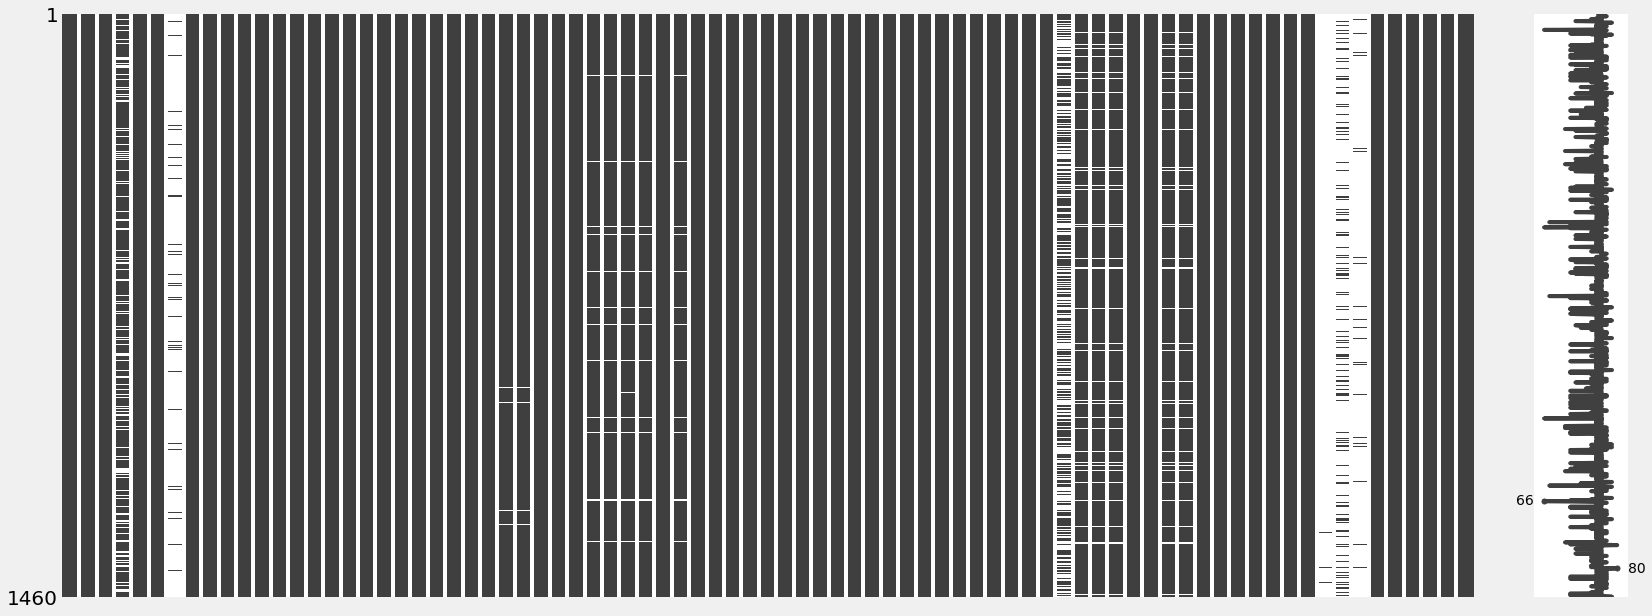

In [9]:
# Check missing values
msno.matrix(df_train_raw)

The white space idicate missing value, and we can see that we have quite a lot of missing value. We will deal this by using imputation for quantitative value and by adding a NA column for qualitative value

In [10]:
def missing_percentage(df):
    """This function takes a DataFrame(df) as input and returns two columns, total missing values and total missing values percentage"""
    ## the two following line may seem complicated but its actually very simple. 
    total = df.isnull().sum().sort_values(ascending = False)[df.isnull().sum().sort_values(ascending = False) != 0]
    percent = round(df.isnull().sum().sort_values(ascending = False)/len(df)*100,2)[round(df.isnull().sum().sort_values(ascending = False)/len(df)*100,2) != 0]
    return pd.concat([total, percent], axis=1, keys=['Total','Percent'])

missing_percentage(df_train_raw).T# train

,PoolQC,MiscFeature,Alley,Fence,FireplaceQu,LotFrontage,GarageYrBlt,GarageCond,GarageType,GarageFinish,GarageQual,BsmtFinType2,BsmtExposure,BsmtQual,BsmtCond,BsmtFinType1,MasVnrArea,MasVnrType,Electrical
Total,1453.00,1406.0,1369.00,1179.00,690.00,259.00,81.00,81.00,81.00,81.00,81.00,38.0,38.0,37.00,37.00,37.00,8.00,8.00,1.00
Percent,99.52,96.3,93.77,80.75,47.26,17.74,5.55,5.55,5.55,5.55,5.55,2.6,2.6,2.53,2.53,2.53,0.55,0.55,0.07


# Tests for relationships between variables

## Numericals: Spearman Correlation

In [11]:
from scipy.stats import spearmanr

def spearman_corr(df: pd.DataFrame, target: str) -> pd.DataFrame:

    test_num_list = []
    test_num_cols = []
    num_cols = df.select_dtypes(include=['int64', 'float64']).columns.drop(target)
    
  
    valid_data = df[[target] + list(num_cols)].dropna()
    
    for num_col in num_cols:
   
        correlation, p_value = spearmanr(valid_data[num_col], valid_data[target])
        
        test_num_list.append([correlation, np.round(p_value, 5)])
        test_num_cols.append(num_col)
    

    return pd.DataFrame(test_num_list, index=test_num_cols, columns=['correlation', 'p_value']).sort_values(by="correlation", ascending=False)

spearman_corr(df_train_raw, "SalePrice").T


,OverallQual,GrLivArea,YearBuilt,GarageCars,FullBath,GarageArea,GarageYrBlt,TotalBsmtSF,YearRemodAdd,1stFlrSF,...,MSSubClass,YrSold,BsmtHalfBath,Id,LowQualFinSF,BsmtFinSF2,MiscVal,OverallCond,KitchenAbvGr,EnclosedPorch
correlation,0.827108,0.724977,0.670198,0.668072,0.651158,0.631303,0.626219,0.618298,0.617311,0.58293,...,-0.006463,-0.01765,-0.03940,-0.041634,-0.05342,-0.076098,-0.091906,-0.174955,-0.176453,-0.241362
p_value,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,...,0.828870,0.55496,0.18743,0.163620,0.07380,0.010810,0.002070,0.000000,0.000000,0.000000


The result of test is that there are a couple of numerical features which have a p-value smaller than 0.05. This means that for these features there is a statistical significant relation between them and the target. Therefore we continu or analysis with a visual inspection of each numerical feature.



In [12]:
# corr = pd.Series(df_train_raw.corr("spearman").SalePrice.sort_values(ascending = False).head(20)) # Most Correlated features)
# display(corr)
# corr = list(corr)

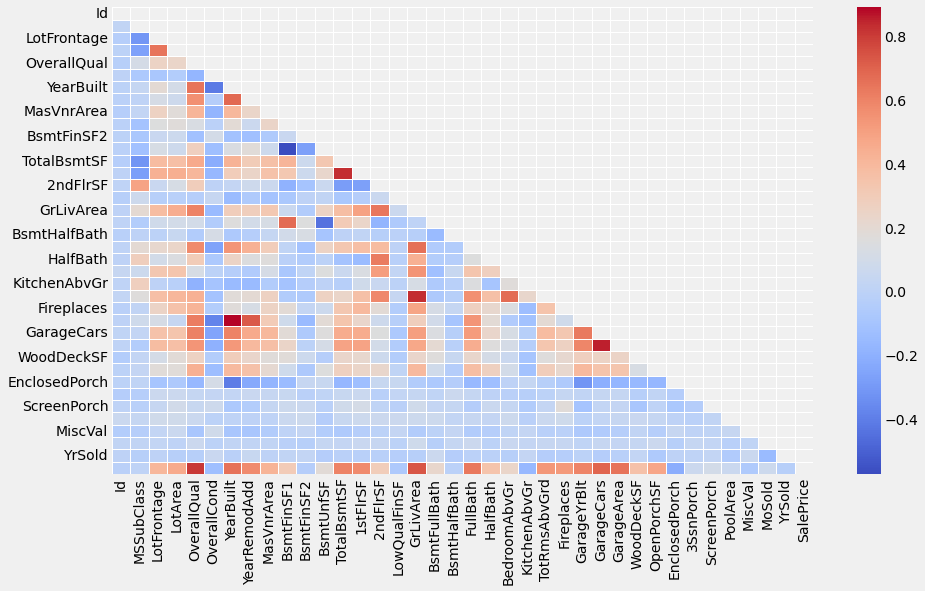

CPU times: user 775 ms, sys: 198 ms, total: 972 ms
Wall time: 707 ms


In [13]:
%%time
mask = np.triu(np.ones_like(df_train_raw.corr("spearman"), dtype=bool))
plt.figure(figsize=(14, 8))
sns.heatmap(df_train_raw.corr("spearman"), annot=False, linewidth=0.5, mask=mask, cmap='coolwarm')
plt.show()


Based on the most correlated and meaningful variables, we can focus our analysis on searching for anomalies and/or outliers.

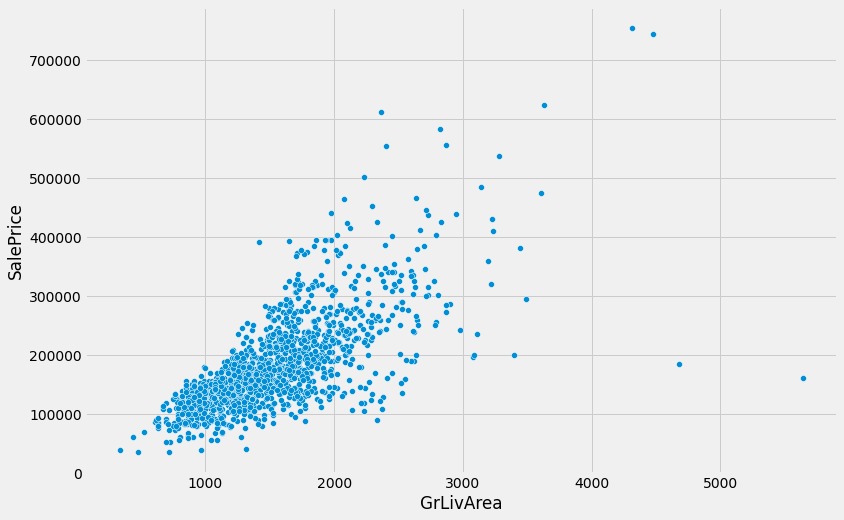

In [14]:
def customized_scatterplot(y, x):
        ## Sizing the plot. 
    plt.subplots(figsize = (12,8))
    ## Plotting target variable with predictor variable(OverallQual)
    sns.scatterplot(y = y, x = x)

customized_scatterplot(df_train_raw.SalePrice, df_train_raw.GrLivArea) # OverallQual   # GarageCars # YearBuilt

**Highly correlated feature, these outliers complicate the linear relationship, they will be eliminated**

In [15]:
# Outliers
display(df_train_raw[df_train_raw.GrLivArea > 4500])

# df_train_raw = df_train_raw[df_train_raw.GrLivArea < 4500]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
523,524,60,RL,130.0,40094,Pave,NaN,IR1,Bnk,AllPub,...,0,NaN,NaN,NaN,0,10,2007,New,Partial,184750
1298,1299,60,RL,313.0,63887,Pave,NaN,IR3,Bnk,AllPub,...,480,Gd,NaN,NaN,0,1,2008,New,Partial,160000


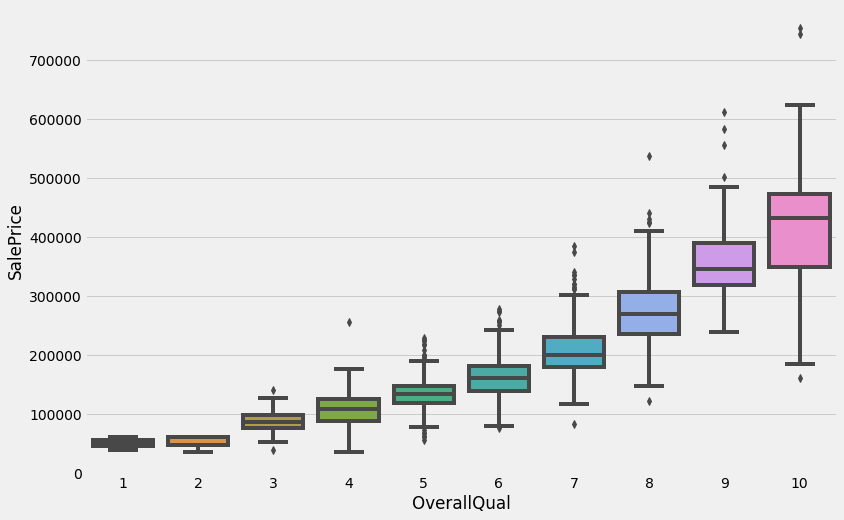

In [16]:
def customized_boxplot(y, x):
        ## Sizing the plot. 
    plt.subplots(figsize = (12,8))
    ## Plotting target variable with predictor variable(OverallQual)
    sns.boxplot(y = y, x = x)

customized_boxplot(df_train_raw.SalePrice, df_train_raw.OverallQual) #    

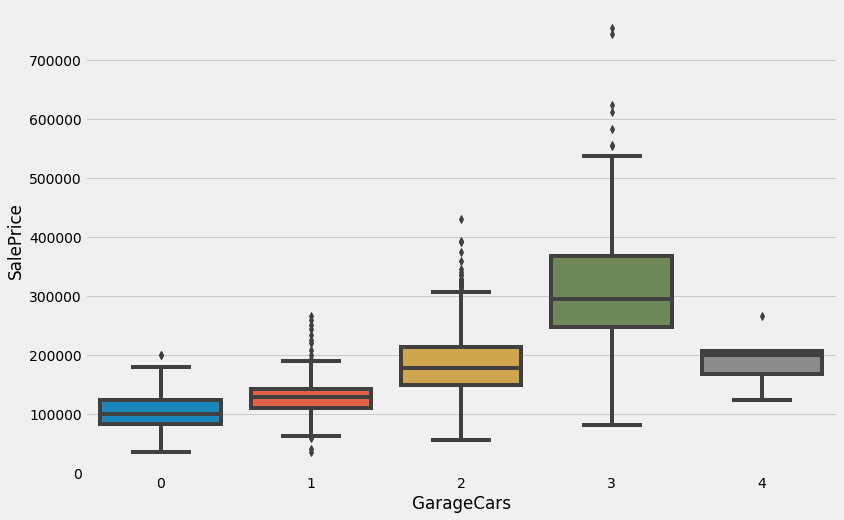

In [17]:
customized_boxplot(df_train_raw.SalePrice, df_train_raw.GarageCars) #

## Categorical features. ANOVA and Kruskal-Wallis Test's

The goal is the check if there is a statistical significant relationship between the categories and the target 'SalePrice'. A way we can do this is by using a one-way ANOVA test or the Kruskal-Wallis H-test. The one-way ANOVA tests the null hypothesis that two or more groups have the same population mean. The Kruskal-Wallis H-test tests the null hypothesis that the population median of all of the groups are equal. It is a non-parametric version of ANOVA. Because the ANOVA has some underlying assumptions we use both to check for a statistical significant relaton between the categorical features and the target

In [18]:
from scipy.stats import f_oneway, kruskal
import pandas as pd

def cat_kruskal(train_df: pd.DataFrame, target: str) -> pd.DataFrame:
    test_cat_list = []
    test_cat_cols = []

    # Identificar columnas categóricas
    cat_cols = train_df.select_dtypes(include=['object', 'category']).columns
    
    for col in cat_cols:
        # Agrupar los valores del target por las categorías de la columna
        test_group = train_df.groupby(col)[target].apply(list)
        
        # Pruebas estadísticas
        f_oneway_result = f_oneway(*test_group)
        kruskal_result = kruskal(*test_group)
    
        # Evaluar conclusiones según los p-valores
        anova_conclusion = (
            "Significant differences (p < 0.05)"
            if f_oneway_result.pvalue < 0.05
            else "No significant differences (p ≥ 0.05)"
        )
        kruskal_conclusion = (
            "Significant differences (p < 0.05)"
            if kruskal_result.pvalue < 0.05
            else "No significant differences (p ≥ 0.05)"
        )
        
        # Agregar resultados y conclusiones
        test_cat_list.append([
            f_oneway_result.statistic, f_oneway_result.pvalue, anova_conclusion,
            kruskal_result.statistic, kruskal_result.pvalue, kruskal_conclusion
        ])
        test_cat_cols.append(col)
    
    # Crear DataFrame con resultados
    return pd.DataFrame(
        test_cat_list,
        index=test_cat_cols,
        columns=[
            'anova_statistic', 'anova_pvalue', 'anova_conclusion',
            'kruskal_statistic', 'kruskal_pvalue', 'kruskal_conclusion'
        ]
    )


# Llamar a la función
results = cat_kruskal(df_train_raw, "SalePrice")
display(results)


,anova_statistic,anova_pvalue,anova_conclusion,kruskal_statistic,kruskal_pvalue,kruskal_conclusion
MSZoning,43.840282,8.817634e-35,Significant differences (p < 0.05),270.070197,3.080724e-57,Significant differences (p < 0.05)
Street,2.459290,1.170486e-01,No significant differences (p ≥ 0.05),3.062353,8.012556e-02,No significant differences (p ≥ 0.05)
Alley,35.562060,4.899826e-08,Significant differences (p < 0.05),32.530421,1.173413e-08,Significant differences (p < 0.05)
LotShape,40.132852,6.447524e-25,Significant differences (p < 0.05),150.954173,1.640323e-32,Significant differences (p < 0.05)
LandContour,12.850188,2.742217e-08,Significant differences (p < 0.05),35.309552,1.047923e-07,Significant differences (p < 0.05)
Utilities,0.298804,5.847168e-01,No significant differences (p ≥ 0.05),0.407369,5.233080e-01,No significant differences (p ≥ 0.05)
LotConfig,7.809954,3.163167e-06,Significant differences (p < 0.05),35.723906,3.297912e-07,Significant differences (p < 0.05)
LandSlope,1.958817,1.413964e-01,No significant differences (p ≥ 0.05),3.938837,1.395380e-01,No significant differences (p ≥ 0.05)
Neighborhood,71.784865,1.558600e-225,Significant differences (p < 0.05),868.532376,6.696799e-168,Significant differences (p < 0.05)
Condition1,6.118017,8.904549e-08,Significant differences (p < 0.05),74.403863,6.492600e-13,Significant differences (p < 0.05)


Almost at the end. When interpreting the feature importance of our model, statistically insignificant features are considered unimportant and should be removed for two main reasons.

# Preprocessing data

In [19]:
# Preprocessing function
def preprocess(df):
    df = df.copy() # Make copy so we don't ruin the original dataframe
    df = df.drop(columns=["Id"], errors='ignore') # Drop Id column
    
    numeric_cols = df.select_dtypes(np.number).columns # Numerical column name
    numeric_cols = numeric_cols.drop("SalePrice", errors='ignore') # Drop label
    categorical_cols =  df.select_dtypes(include=['object']).columns # Categorical column name
    
    df_categorical = pd.get_dummies(df[categorical_cols], dummy_na=True) # OneHotEncoding, dummy_na create another column to indicate if the cell contain NA
    
    df_numerical = df[numeric_cols].apply(lambda x: (x - x.mean()) / (x.std())) # Normalize every numerical column
    df_numerical = df_numerical.fillna(0) # Fill in missing value with mean 0
    
    df = pd.concat([df_numerical, df_categorical], axis=1) # Bind numerical column and categorical column
    
    return df

In [20]:
# Get inputs and target
df_train_y = df_train_raw["SalePrice"].copy() # Copy the target
df_train_y = np.log(df_train_y, where=df_train_y != 0) # Scale the target
df_train_X = preprocess(df_train_raw) # Preprocess the inputs

In [21]:
# Check our new processed dataframe
df_train_X.tail()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,SaleType_Oth,SaleType_WD,SaleType_nan,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,SaleCondition_nan
1455,0.073350,-0.331482,-0.260471,-0.071812,-0.517023,0.918196,0.733056,-0.572637,-0.972685,-0.288554,...,0,1,0,0,0,0,0,1,0,0
1456,-0.872264,0.615614,0.266316,-0.071812,0.381612,0.222899,0.151813,0.084581,0.759399,0.721865,...,0,1,0,0,0,0,0,1,0,0
1457,0.309753,-0.166770,-0.147760,0.651256,3.077516,-1.002149,1.023678,-0.572637,-0.369744,-0.288554,...,0,1,0,0,0,0,0,1,0,0
1458,-0.872264,-0.084413,-0.080133,-0.794879,0.381612,-0.704164,0.539309,-0.572637,-0.865252,6.090101,...,0,1,0,0,0,0,0,1,0,0
1459,-0.872264,0.203833,-0.058092,-0.794879,0.381612,-0.207523,-0.962236,-0.572637,0.847099,1.509123,...,0,1,0,0,0,0,0,1,0,0


<AxesSubplot:xlabel='SalePrice', ylabel='Count'>

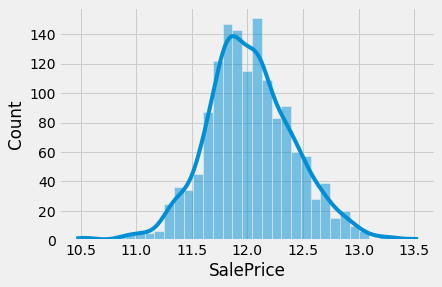

In [22]:
# Check the distribution of the data
sns.histplot(df_train_y, kde=True)

Now the values seems more symmetrical and close to each other

In [23]:
# Split the data into 80% training and 20% validation
df_train_X, df_val_X, df_train_y, df_val_y = train_test_split(df_train_X, df_train_y, 
                                                                        train_size=0.8, random_state=42)


# Model Building

In [24]:
# Building a model
class Model(nn.Module):
    def __init__(self, D_in=331, H=222, D_out=1, Hn=4):
        super().__init__()
        self.Hn = Hn # Number of hidden layer
        self.activation = nn.Softplus() # Activation function
        
        self.layers = nn.ModuleList([nn.Linear(D_in, H), self.activation]) # First hidden layer
        for i in range(self.Hn - 1):
            self.layers.extend([nn.Linear(H, H), self.activation]) # Add hidden layer
        self.layers.append(nn.Linear(H, D_out)) # Output layer
        
    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

- D_in is the number of input
- D_out is the number of output
- H is the number of neuron in each layer, which we can simply use D_in*2/3 + D_out
- Hn is the number of hidden layer

# Model Training

In [25]:
# Setting seed for reproducibility
def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.use_deterministic_algorithms = True
    
# Set seed for reproducibility
set_seed(123)

In [26]:
# Set device to gpu (cuda) if it's available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [27]:
# Data for validation
y_val = torch.tensor(df_val_y.values).float().to(device).unsqueeze(1) # Unsqueeze to match the shape of the output of our model
X_val = torch.tensor(df_val_X.values).float().to(device)

# Prepare data for batch training
y_train = torch.tensor(df_train_y.values).float().to(device).unsqueeze(1) # Unsqueeze to match the shape of the output of our model
X_train = torch.tensor(df_train_X.values).float().to(device)
dataset = TensorDataset(X_train, y_train) # Make X,y into dataset so we can work with DataLoader which iterate our data in batch size
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

# Define Model,Optimizer, Criterion
model = Model().to(device) # Define model and send to gpu
optimizer = torch.optim.SGD(model.parameters(), lr=0.002, momentum=0.9, weight_decay=0.001) # What approach we use to minimize the gradient
criterion = nn.MSELoss() # Our loss function

In [28]:
train_losses = [] # Store the training loss
val_losses = [] # Store the validation loss
epochs = 250 # Number of time we go over the whole dataset

for epoch in range(epochs):
    running_loss = 0.0
    
    for batch, (X,y) in enumerate(dataloader):
        # Forward propagation
        y_pred = model(X) # Make prediction by passing X to our model
        loss = criterion(y_pred, y) # Calculate loss 
        running_loss += loss.item() # Add loss to running loss
        
        # Backward propagation
        optimizer.zero_grad() # Empty the gradient (look up this function)
        loss.backward() # Do backward propagation and calculate the gradient of loss with respect to every parameters (that require gradient)
        optimizer.step() # Adjust parameters to minimize loss
    
    # Append train loss
    train_losses.append(running_loss/(batch + 1)) # Add the average loss of this iteration to training loss
    
    # Check test loss
    y_pred = model(X_val)
    val_loss = criterion(y_pred, y_val).item()
    val_losses.append(val_loss)

# Model Evaluation

In [29]:
# Plotting loss
def plot_loss(losses, axes=None, epoch_start = 0):
    sns.set_theme(style="darkgrid")
    x = [i for i in range(1 + epoch_start, len(losses) + 1)]
    sns.lineplot(ax=axes, x=x, y=losses[epoch_start:])
    
    
def plot_epoch_loss(train_losses, test_losses, epoch1=0, epoch2=10, epoch3=50, epoch4=150):
    fig, axes = plt.subplots(2, 2, figsize=(12,6), constrained_layout = True)
    fig.suptitle("Losses against Epochs")

    axes[0][0].set_title('Epoch Start at ' + str(epoch1))
    plot_loss(train_losses, axes[0][0], epoch1)
    plot_loss(test_losses, axes[0][0], epoch1)

    axes[0][1].set_title('Epoch Start at ' + str(epoch2))
    plot_loss(train_losses, axes[0][1], epoch2)
    plot_loss(test_losses, axes[0][1], epoch2)

    axes[1][0].set_title('Epoch Start at ' + str(epoch3))
    plot_loss(train_losses, axes[1][0], epoch3)
    plot_loss(test_losses, axes[1][0], epoch3)

    axes[1][1].set_title('Epoch Start at ' + str(epoch4))
    plot_loss(train_losses, axes[1][1], epoch4)
    plot_loss(test_losses, axes[1][1], epoch4)

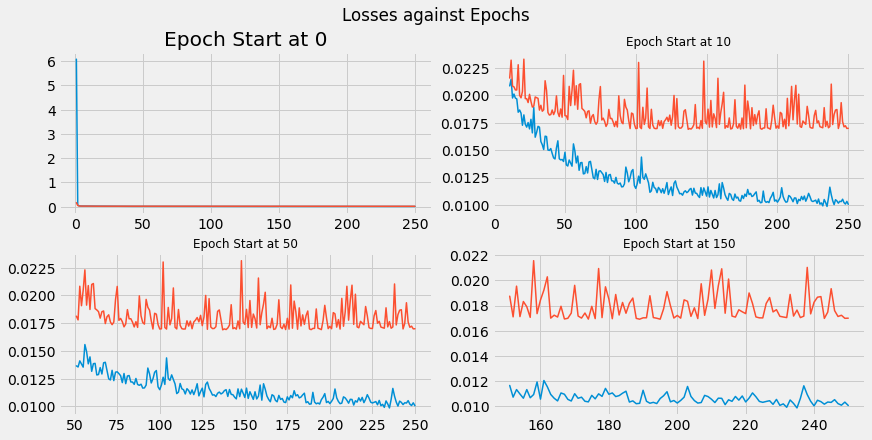

In [30]:
plot_epoch_loss(train_losses, val_losses)

In [31]:
# Calculate the errors and turn into numpy array
def numpy_error(model, X, y, exp=True):
    y_pred = model(X)
    if exp:
        y = torch.exp(y)
        y_pred = torch.exp(y_pred)

    errors = (y_pred - y).flatten().detach().cpu().numpy()
    return errors

# Calculate the mean absolute error
def mae(errors):
    return np.abs(errors).mean()

# Calculate the root mean squared error
def rmse(errors):
    mse = ((errors)**2).mean()
    return np.sqrt(mse)

In [32]:
# Error on full training set 
errors = numpy_error(model, X_train, y_train, False)
print("Error on training set")
print(f"MAE: {mae(errors)}\nRMSE: {rmse(errors)}")

# Error on testing set
errors = numpy_error(model, X_val, y_val, False)
print("\nError on testing set")
print(f"MAE: {mae(errors)}\nRMSE: {rmse(errors)}")

Error on training set
MAE: 0.06746222078800201
RMSE: 0.09724729508161545

Error on testing set
MAE: 0.08699536323547363
RMSE: 0.13036629557609558


# Submission

In [33]:
# Load the data and save the Id
df_test = pd.read_csv(r'/kaggle/input/house-prices-advanced-regression-techniques/test.csv')
submission_id = df_test["Id"].copy()

In [34]:
# Check for missing columns on submission inputs (after preprocessing)
X_submission = preprocess(df_test)
train_cols = df_train_X.columns
submission_cols = X_submission.columns
diff = train_cols.difference(submission_cols)
print(diff)

Index(['Condition2_RRAe', 'Condition2_RRAn', 'Condition2_RRNn',
       'Electrical_Mix', 'Exterior1st_ImStucc', 'Exterior1st_Stone',
       'Exterior2nd_Other', 'GarageQual_Ex', 'Heating_Floor', 'Heating_OthW',
       'HouseStyle_2.5Fin', 'MiscFeature_TenC', 'PoolQC_Fa',
       'RoofMatl_ClyTile', 'RoofMatl_Membran', 'RoofMatl_Metal',
       'RoofMatl_Roll', 'Utilities_NoSeWa'],
      dtype='object')


In [35]:
# We can fix this by adding a few rows and on each row we add the value that is missing on specific column (before encoding)
added_rows = 0 
idx = len(df_test) # Where added row should be modified

df_test_copy = df_test.copy() # Copy so we don't ruin the dataframe
eg_row = df_test.iloc[0] # Example row

for string in diff:
    df_test_copy.append(eg_row) # Append the example row at the end of dataframe
    col, value = string.split('_') # Split into column and value
    df_test_copy.loc[idx, col] = value
    idx += 1
    added_rows += 1

In [36]:
df_test_copy = preprocess(df_test_copy) # Preprocess the copy
X_submission = df_test_copy.drop(df_test_copy.tail(added_rows).index) # Remove the added rows
X_submission = torch.tensor(X_submission.values).float().to(device) # Change it into tensor for our model

In [37]:
y_submission = model(X_submission).squeeze() # Make it into array
y_submission = torch.exp(y_submission) # Scale back to normal value 
y_submission = y_submission.cpu().detach().numpy() # Change to numpy
submission = pd.DataFrame({"Id":submission_id, "SalePrice":y_submission}) # Make dataframe for submissino
submission.to_csv('submission.csv', index=False) # Put into csv file

***